<a href="https://colab.research.google.com/github/harperd17/energy_volatility_prediction/blob/main/notebooks/Modeling/Prod_Sklearn_withlogger_DH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The goal of this notebook is to determine which model returns the highest R2 by feature reduction techniques and hp tuning

## This will set the prefix of your log file name

In [ ]:
name = "David"
#Not grid "adamgoldsteindatascience/energyprice-volatility-grid"

neptune_project_name = "adamgoldsteindatascience/energyprice-volatility"

#Overall Reproduceability
random_state = 0

In [ ]:
# Clones the main branch githubt to import: 
# 1.from fengine import Fengine
# 2.from sklearnlogger import SklearnLogger
!git clone https://github.com/harperd17/energy_volatility_prediction.git

Cloning into 'energy_volatility_prediction'...
remote: Enumerating objects: 472, done.
remote: Counting objects: 100% (472/472), done.
remote: Compressing objects: 100% (454/454), done.
remote: Total 472 (delta 276), reused 16 (delta 9), pack-reused 0
Receiving objects: 100% (472/472), 6.77 MiB | 10.81 MiB/s, done.
Resolving deltas: 100% (276/276), done.


In [ ]:
!pip install neptune-client --quiet
import neptune.new as neptune

     |████████████████████████████████| 276 kB 5.2 MB/s 
     |████████████████████████████████| 829 kB 27.2 MB/s 
     |████████████████████████████████| 52 kB 837 kB/s 
     |████████████████████████████████| 180 kB 60.0 MB/s 
     |████████████████████████████████| 131 kB 56.2 MB/s 
     |████████████████████████████████| 79 kB 6.6 MB/s 
     |████████████████████████████████| 8.3 MB 25.5 MB/s 
     |████████████████████████████████| 138 kB 64.1 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 127 kB 52.5 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 130 kB 56.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import sys
sys.path.append("energy_volatility_prediction/helpers/")

from sklearn.model_selection import train_test_split as tts

import matplotlib.pyplot as plt

from fengine import Fengine
from sklearnlogger import SklearnLogger
import warnings

from google.colab import drive

drive.mount('./drive/')

%cd drive/Shareddrives/Data606_Energy

Mounted at ./drive/
/content/drive/Shareddrives/Data606_Energy


In [ ]:
!pip install optuna
import optuna

     |████████████████████████████████| 308 kB 5.1 MB/s 
     |████████████████████████████████| 209 kB 39.6 MB/s 
     |████████████████████████████████| 80 kB 6.6 MB/s 
     |████████████████████████████████| 75 kB 3.9 MB/s 
     |████████████████████████████████| 149 kB 56.7 MB/s 
     |████████████████████████████████| 49 kB 4.2 MB/s 
     |████████████████████████████████| 112 kB 52.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=9b3bdda320244d4f4507d159a9b662a55df7f98379a360570af5e817378ed2fa
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


# Feature Scaling

In [ ]:
df = pd.read_csv("data/merge_ready/merged_data_2001-2020_new_data.csv")

In [ ]:
# Miles

columns_to_scale = ["Agg_total_plant_MWh", "Agg_total_plant_count"]

# I think it is better to just divide by 12 here
columns_to_scale_by_Month = [x for x in df if "Months" in x]

columns_to_categorize = ["State"]

columns_to_drop = ["Year"] # Not sure if this is appropriate to keep after matching the data

try:
    df[columns_to_scale] = MinMaxScaler().fit_transform(df[columns_to_scale])
    df[columns_to_scale].head(3)
except:
    # Just means that files were left out for additional rows
    pass

df[columns_to_scale_by_Month] /= 12 
df[columns_to_scale_by_Month].head(3)

,Months Above Average Price Movement BZ=F,Months Above Average Price Volume BZ=F,Months Above Average Price Movement NG=F,Months Above Average Price Volume NG=F,Months Above Average Price Movement CL=F,Months Above Average Price Volume CL=F,Months Above Average Price Movement HO=F,Months Above Average Price Volume HO=F,Hot Summer Months,Cold Winter Months,Dry Summer Months
0,0.0,0.0,0.583333,0.583333,0.583333,0.583333,0.333333,0.333333,0.0,0.166667,0.333333
1,0.0,0.0,0.583333,0.583333,0.583333,0.583333,0.333333,0.333333,0.0,0.250000,0.333333
2,0.0,0.0,0.583333,0.583333,0.583333,0.583333,0.333333,0.333333,0.0,0.333333,0.333333


In [ ]:
#https://stackoverflow.com/questions/51102205/how-to-know-the-labels-assigned-by-astypecategory-cat-codes
# Miles

# not using columns_to_categorize because it is just `State`
codes = df.State.astype("category")

state_codes = dict(enumerate(codes.cat.categories))
# print(state_codes)

df["State"] = df.State.astype("category").cat.codes
df["State"].head(3)

0    0
1    1
2    2
Name: State, dtype: int8

In [ ]:
# Don't know if we want to keep year
df = df.drop(columns=["Year","year.1"])

In [ ]:
df

,State,Months Above Average Price Movement BZ=F,Months Above Average Price Volume BZ=F,Months Above Average Price Movement NG=F,Months Above Average Price Volume NG=F,Months Above Average Price Movement CL=F,Months Above Average Price Volume CL=F,Months Above Average Price Movement HO=F,Months Above Average Price Volume HO=F,Hot Summer Months,Cold Winter Months,Dry Summer Months,COV,target_COV,COM_percapita_mean_kWh_electricacc,RES_percapita_mean_kWh_electricacc,COM_percapita_mean_kWh_statepop,RES_percapita_mean_kWh_statepop,Agg_total_plant_MWh_x,Agg_total_plant_count_x,R_AB_MWh,R_AB_count,R_BFG_MWh,R_BFG_count,R_BIT_MWh,R_BIT_count,R_BLQ_MWh,R_BLQ_count,R_DFO_MWh,R_DFO_count,R_GEO_MWh,R_GEO_count,R_JF_MWh,R_JF_count,R_KER_MWh,R_KER_count,R_LFG_MWh,R_LFG_count,R_LIG_MWh,R_LIG_count,...,R_TDF_MWh,R_TDF_count,R_WAT_MWh,R_WAT_count,R_WC_MWh,R_WC_count,R_WDS_MWh,R_WDS_count,R_WH_MWh,R_WH_count,R_WND_MWh,R_WND_count,R_WO_MWh,R_WO_count,Agg_R_Biomass_MWh,Agg_R_Biomass_count,Agg_R_Coal_MWh,Agg_R_Coal_count,Agg_R_Geothermal_MWh,Agg_R_Geothermal_count,Agg_R_Hydroelectric_MWh,Agg_R_Hydroelectric_count,Agg_R_Municipal_Waste_MWh,Agg_R_Municipal_Waste_count,Agg_R_Natural_Gas_MWh,Agg_R_Natural_Gas_count,Agg_R_Nuclear_MWh,Agg_R_Nuclear_count,Agg_R_Oil_Gas_MWh,Agg_R_Oil_Gas_count,Agg_R_Other_MWh,Agg_R_Other_count,Agg_R_Solar_MWh,Agg_R_Solar_count,Agg_R_Wind_MWh,Agg_R_Wind_count,Agg_R_batteries_or_other_use_of_electricity_as_an_energy_source_MWh,Agg_R_batteries_or_other_use_of_electricity_as_an_energy_source_count,Agg_total_plant_MWh_y,Agg_total_plant_count_y
0,0,0.0,0.000000,0.583333,0.583333,0.583333,0.583333,0.333333,0.333333,0.000000,0.166667,0.333333,0.035090,0.023952,0.075,0.010,0.435,0.360,5.517773e+06,1032,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.051,0.581,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,...,0.0,0.000,0.243,0.256,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.012,0.000,0.000,0.000,0.000,0.058,0.035,0.000,0.000,0.243,0.256,0.000,0.000,0.543,0.093,0.000,0.000,0.157,0.605,0.000,0.000,0.000,0.000,0.000,0.012,0.000,0.000,5.517773e+06,1032
1,1,0.0,0.000000,0.583333,0.583333,0.583333,0.583333,0.333333,0.333333,0.000000,0.250000,0.333333,0.030268,0.041504,0.017,0.005,0.240,0.354,1.074304e+08,1089,0.000,0.000,0.0,0.0,0.351,0.110,0.017,0.087,0.003,0.159,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.011,0.0,0.0,...,0.0,0.000,0.082,0.253,0.0,0.000,0.011,0.077,0.0,0.0,0.000,0.000,0.000,0.000,0.028,0.175,0.523,0.121,0.000,0.000,0.082,0.253,0.000,0.000,0.082,0.236,0.283,0.022,0.003,0.192,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.074304e+08,1089
2,2,0.0,0.000000,0.583333,0.583333,0.583333,0.583333,0.333333,0.333333,0.000000,0.333333,0.333333,0.067610,0.065392,0.082,0.018,0.223,0.368,4.683797e+07,615,0.000,0.000,0.0,0.0,0.002,0.015,0.023,0.073,0.001,0.098,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0,...,0.0,0.007,0.054,0.312,0.0,0.000,0.007,0.055,0.0,0.0,0.000,0.000,0.000,0.018,0.031,0.148,0.529,0.073,0.000,0.000,0.054,0.312,0.000,0.000,0.052,0.195,0.316,0.020,0.019,0.234,0.000,0.018,0.000,0.000,0.000,0.000,0.000,0.000,4.683797e+07,615
3,3,0.0,0.000000,0.583333,0.583333,0.583333,0.583333,0.333333,0.333333,0.083333,0.333333,0.333333,0.097578,0.091424,0.048,0.007,0.370,0.439,7.170267e+07,575,0.000,0.000,0.0,0.0,0.010,0.021,0.000,0.000,0.002,0.292,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.021,0.0,0.0,...,0.0,0.000,0.110,0.188,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.021,0.312,0.104,0.000,0.000,0.110,0.188,0.000,0.000,0.173,0.290,0.401,0.021,0.004,0.355,0.000,0.000,0.000,0.021,0.000,0.000,0.000,0.000,7.170267e+07,575
4,4,0.0,0.000000,0.583333,0.583333,0.583333,0.583333,0.333333,0.333333,0.000000,0.333333,0.333333,0.145412,0.071167,0.065,0.008,0.408,0.325,1.343136e+08,6470,0.001,0.002,0.0,0.0,0.007,0.006,0.000,0.000,0.001,0.035,0.087,0.048,0.0,0.000,0.0,0.000,0.006,0.028,0.0,0.0,...,0.0,0.002,0.187,0.440,0.0,0.000,0.018,0.031,0.0,0.0,0.015,0.064,0.001,0.002,0.027,0.075,0.007,0.006,0.087,0.048,0.187,0.440,0.003,0.0

# Column Selection

# TTS Split

In [ ]:
def feature_engineering_pipeline(df,py_library,func_list):

    df_model = df

    for func in func_list:

        method_to_call = getattr(py_library, func[0])

        df_model = df_model.pipe(method_to_call,*func[1:])

        print("Feature Engineering","(",func[0],func[1],")","Complete")

    return df_model


def split_dataset(df,train_size=0.80,target="target_COV"):

    X = df[[col for col in df.columns if col != target]]

    y = df[target]

    X_train,X_test,y_train,y_test = tts(X.to_numpy(),y.to_numpy(),random_state=random_state,train_size=train_size)

    print("Split Dataset into","Train_size =",train_size,"Test_size = ",1-train_size)

    return X,y,X_train,X_test,y_train,y_test

# Import Models

In [ ]:
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import (LinearRegression, Ridge, Lasso,RidgeCV,LassoCV,
                                  ElasticNet,ElasticNetCV,Lars,LarsCV,BayesianRidge,
                                  ARDRegression, PassiveAggressiveRegressor, 
                                  SGDRegressor,TheilSenRegressor,
                                  HuberRegressor,LassoLarsCV,LassoLarsIC)#QuantileRegressor,TweedieRegressor,)

from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor,
                              ExtraTreesRegressor,HistGradientBoostingRegressor,
                              GradientBoostingRegressor,RandomForestRegressor,
                              StackingRegressor,VotingRegressor,
                              )

from sklearn.svm import (LinearSVR,NuSVR,SVR)

from sklearn.model_selection import GridSearchCV, cross_val_score

# Select Models  Detail

In [ ]:
def parameter_intersection(pipeline=[]):
    
    common_parameters = list()

    for model in pipeline:
    
        common_p = set(model.get_params().keys())

        common_parameters.append(common_p)

    # finds the intersection of all set of params
    return set.intersection(*common_parameters)

In [ ]:
#Extract Model name - https://stackoverflow.com/questions/52763325/how-to-obtain-only-the-name-of-a-models-object-in-scikitlearn


from datetime import datetime

warnings.filterwarnings("ignore")

def get_linear_model_hp(key):

    linear_model_hp = {"G1":{'alpha':[0,0.5,1],'max_iter':[300,400,500], 'tol':[1e-7]},
                    "G2":{"cv":[3]},
                    "G3":{'alpha_1':[1e-3,1e-6,1e-9],
                            'alpha_2':[1e-3,1e-6,1e-9],
                            'lambda_1':[1e-3,1e-6,1e-9],
                            'lambda_2':[1e-3,1e-6,1e-9],
                            'n_iter':[100,300,500,700],
                            'tol':[1e-7],
                        },
                    "G4":{
                        'max_iter':[300,400,500],
                        'max_subpopulation':[1e2,1e4,1e6],
                        'n_subsamples':[None,8,16,24,32],
                        'random_state':[random_state],
                        'tol':[1e-7],
                        }
                    
                    }

    return linear_model_hp[key]


def get_ensemble_model_hp(key):

    ensemble_models_hp = {
                    "Trees":{'bootstrap':[False],
                                    'ccp_alpha':[0],
                                    'criterion':["squared_error"],
                                    'max_depth':[10,50,100,200],
                                    'max_features':[None],
                                    'max_leaf_nodes':[20,50,100,200],
                                    'max_samples':[None],
                                    'min_impurity_decrease':[0],
                                    'min_samples_leaf':[1,24,48,64],
                                    'min_samples_split':[1,24,48,64],
                                    'min_weight_fraction_leaf':[0],
                                    'n_estimators':[100,200,300],
                                    'n_jobs':[None],
                                    'oob_score':[False],
                                    'random_state':[random_state]},
                        
                    "Boosting":{'learning_rate':[0.1,0.01,0.001,0.0001],
                                    'loss':["squared_error"],
                                    'max_depth':[10,50,100,200,400,1000],
                                    'max_leaf_nodes':[None],
                                    'min_samples_leaf':[20],
                                    'n_iter_no_change':[10],
                                    'random_state':[random_state],
                                    'tol':[1e-7],
                                    'validation_fraction':[0.1]}#default
                    }

    return ensemble_models_hp[key]


def get_linear_models():

    linear_models = [
            #LinearRegression(),
            #G1
            # (Ridge(),get_linear_model_hp("G1")),
            # (Lasso(),get_linear_model_hp("G1")),
            # (ElasticNet(),get_linear_model_hp("G1")),
            # (HuberRegressor(),get_linear_model_hp("G1")),
            
            # #G2
            # (RidgeCV(cv=5),get_linear_model_hp("G2")),
            # (LassoCV(cv=5),get_linear_model_hp("G2")),
            # (ElasticNetCV(cv=5),get_linear_model_hp("G2")),
            # (LarsCV(cv=5),get_linear_model_hp("G2")),
            # (LassoLarsCV(cv=5),get_linear_model_hp("G2")),

            # #G3
            # (BayesianRidge(),get_linear_model_hp("G3")),
            (ARDRegression(),get_linear_model_hp("G3")),
            

            #G4
            (TheilSenRegressor(),get_linear_model_hp("G4")),
             
    ]

           
            #G5 - Not included
            # SGDRegressor(),
            # PassiveAggressiveRegressor(),
            
            
            # #G6
            # (Lars(),
            # LassoLarsIC(criterion="bic")

    return ("Linear",linear_models)

def get_ensemble_models():

    ensemble_models = [
                    #Tree
                    (ExtraTreesRegressor(),get_ensemble_model_hp("Trees")),
                    (RandomForestRegressor(),get_ensemble_model_hp("Trees")),
                    #Boosting
                    (HistGradientBoostingRegressor(),get_ensemble_model_hp("Boosting")),
                    (GradientBoostingRegressor(),get_ensemble_model_hp("Boosting"))


                    #Regressor - Used with other models like a wrapper
                    # BaggingRegressor(random_state=random_state),
                    # AdaBoostRegressor(random_state=random_state), 
                    
                    

                    ]

    return ("Ensemble",ensemble_models)


def get_svm_models():

    svm_models = [#G1
                  LinearSVR(),

                  #G2
                  NuSVR(),
                  SVR()
                ]

    return ("SVM",svm_models)



In [ ]:
param_lookup = {
    'Lasso':{'alpha':optuna.distributions.LogUniformDistribution(1e-10, 1e10)},
    'Ridge':{'alpha':optuna.distributions.LogUniformDistribution(1e-10, 1e10)},
    'ExtraTreesRegressor':{'ccp_alpha':optuna.distributions.LogUniformDistribution(1e-10, 1e10),
                           'max_depth':optuna.distributions.LogUniformDistribution(10,200),
                           'max_leaf_nodes':optuna.distributions.LogUniformDistribution(20,200),
                           'min_samples_leaf':optuna.distributions.LogUniformDistribution(1,128),
                           'min_samples_split':optuna.distributions.LogUniformDistribution(1,128),
                           'n_estimators':optuna.distributions.LogUniformDistribution(20,300)
                           },
    'RandomForestRegressor':{'ccp_alpha':optuna.distributions.LogUniformDistribution(1e-10, 1e10),
                           'max_depth':optuna.distributions.LogUniformDistribution(10,200),
                           'max_leaf_nodes':optuna.distributions.LogUniformDistribution(20,200),
                           'min_samples_leaf':optuna.distributions.LogUniformDistribution(1,128),
                           'min_samples_split':optuna.distributions.LogUniformDistribution(1,128),
                           'n_estimators':optuna.distributions.LogUniformDistribution(20,300)
                           },
    'HistGradientBoostingRegressor':{'learning_rate':optuna.distributions.LogUniformDistribution(0.00001,0.5),
                                     'max_depth':optuna.distributions.LogUniformDistribution(10,75),
                                      'max_leaf_nodes':optuna.distributions.LogUniformDistribution(20,200),
                                      'min_samples_leaf':optuna.distributions.LogUniformDistribution(1,64)},
    'GradientBoostingRegressor':{'n_estimators':optuna.distributions.DiscreteUniformDistribution(10,5000,1),
                                 'subsample':optuna.distributions.LogUniformDistribution(0.1,1.1),
                                 'max_features':optuna.distributions.DiscreteUniformDistribution(1,50,1),
                                 'learning_rate':optuna.distributions.LogUniformDistribution(0.000001,1),
                                 'max_depth':optuna.distributions.DiscreteUniformDistribution(1,20,1)},
        # 'alpha':optuna.distributions.LogUniformDistribution(0.0000001,1000000),
        #                          'ccp_alpha':optuna.distributions.LogUniformDistribution(0.0000001,1000000),
        #                             'learning_rate':optuna.distributions.LogUniformDistribution(0.00001,0.5),
        #                              'max_depth':optuna.distributions.LogUniformDistribution(10,75),
        #                               'max_leaf_nodes':optuna.distributions.LogUniformDistribution(20,200),
        #                               'min_samples_leaf':optuna.distributions.LogUniformDistribution(1,64),
        #                               'min_samples_split':optuna.distributions.LogUniformDistribution(1,64)},
      'XGBRegressor':{'objective':optuna.distributions.CategoricalDistribution('reg:linear'),
                      'colsample_bytree':optuna.distributions.LogUniformDistribution(0.0000001,1),
                      'eta':optuna.distributions.LogUniformDistribution(0.0001,0.5),
                      #'max_depth':optuna.distributions.LogUniformDistribution(5,200),
                      #'alpha':optuna.distributions.LogUniformDistribution(0.0001,1000),
                      'n_estimators':optuna.distributions.LogUniformDistribution(5,100),
                      'subsample':optuna.distributions.LogUniformDistribution(0.00001,1)}

}

In [ ]:
def objective_gradient_boosting_regressor(trial):   
  n_estimators = int(trial.suggest_int('n_estimators',10,5000))
  subsample = trial.suggest_loguniform('subsample',0.1,1)
  max_features = int(trial.suggest_int('max_features',1,50))
  learning_rate = trial.suggest_loguniform('learning_rate',0.000001,1)
  max_depth = int(trial.suggest_int('max_depth',1,20))
  # print(n_estimators)
  # print(subsample)
  # print(max_features)
  # print(learning_rate)
  # print(max_depth)

  model = GradientBoostingRegressor(n_estimators=int(n_estimators),subsample=subsample,max_features=int(max_features),learning_rate=learning_rate,max_depth=int(max_depth))
  # print(model)
  # model.fit(X_train,y_train)
  scores = cross_val_score(model,X_train,y_train,cv=5)
  # print(scores)
  return scores.mean()


In [ ]:
def objective_hist_gradient_boosting_regressor(trial):   
  max_iter = trial.suggest_int('max_iter',1,500)
  learning_rate = trial.suggest_loguniform('learning_rate',0.000001,1)
  max_depth = trial.suggest_int('max_depth',1,20)
  # print(n_estimators)
  # print(subsample)
  # print(max_features)
  # print(learning_rate)
  # print(max_depth)

  model = HistGradientBoostingRegressor(max_iter=max_iter,learning_rate=learning_rate,max_depth=int(max_depth))
  # print(model)
  # model.fit(X_train,y_train)
  scores = cross_val_score(model,X_train,y_train,cv=5)
  # print(scores)
  return scores.mean()

In [ ]:
def objective_lasso(trial):
  alpha = trial.suggest_float('alpha',1e-10, 1e10)
  model = Lasso(alpha=alpha)
  scores = cross_val_score(model,X_train,y_train)

  return scores.mean()

In [ ]:
def objective_ridge(trial):
  alpha = trial.suggest_float('alpha',1e-10, 1e10)
  model = Ridge(alpha=alpha)
  scores = cross_val_score(model,X_train,y_train)

  return scores.mean()

In [ ]:
def objective_extra_trees_regressor(trial):
  n_estimators = trial.suggest_int('n_estimators',10,5000)
  max_features = trial.suggest_int('max_features',1,30)
  max_samples = trial.suggest_int('max_samples',2,20)

  model = ExtraTreesRegressor(n_estimators=n_estimators,max_features=max_features,max_samples=max_samples)
  scores = cross_val_score(model,X_train,y_train)

  return scores.mean()

In [ ]:
def objective_random_forest_regressor(trial):
  max_samples = trial.suggest_float('max_samples',0.0001,0.9999)
  max_features = trial.suggest_int('max_features',1,30)
  n_estimators = trial.suggest_int('n_estimators',10,5000)
  max_depth = trial.suggest_int('max_depth',2,20)

  model = RandomForestRegressor(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,max_samples=max_samples)
  scores = cross_val_score(model,X_train,y_train)

  return scores.mean()

In [ ]:
def objective_xgboost(trial):
  reg_lambda = trial.suggest_float('reg_lambda',0.00001,1)
  reg_alpha = trial.suggest_float('reg_alpha',0.0001,10)
  colsample_bytree = trial.suggest_float('colsample_bytree',0.1,1.0)
  subsample = trial.suggest_float('subsample',0.3,1.0)
  learning_rate = trial.suggest_float('learning_rate',0.0001,1)
  n_estimators = trial.suggest_int('n_estimators',10,5000)
  max_depth = trial.suggest_int('max_depth',1,25)
  min_child_weight = trial.suggest_int('min_child_weight',1,300)

  model = xgb.XGBRegressor(reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                           colsample_bytree=colsample_bytree,subsample=subsample,
                           learning_rate=learning_rate,n_estimators=n_estimators,
                           max_depth=max_depth,min_child_weight=min_child_weight)
  scores = cross_val_score(model,X_train,y_train)

  return scores.mean()

In [ ]:
model_functions = {'GradientBoostingRegressor':objective_gradient_boosting_regressor,
                   'HistGradientBoostingRegressor':objective_hist_gradient_boosting_regressor,
                   'Lasso':objective_lasso,
                   'Ridge':objective_ridge,
                   'ExtraTreesRegressor':objective_extra_trees_regressor,
                   'RandomForestRegressor':objective_random_forest_regressor,
                   'XGBRegressor':objective_xgboost

                   }

In [ ]:
def get_ft(model,label):

    try:

        if label == "Linear":

            return model.coef_

        if label == "Ensemble":

            return model.feature_importances_

    except:

        None
# def objective_tree(trial,X_train,y_train,param,model):  
#   n_estimators = trial.suggest_loguniform(10,5000)
#   subsample=trial.suggest_loguniform(0.1,1.1)
#   max_features = trial.suggest_loguniform(1,50)
#   learning_rate = trial.suggest_loguniform(0.000001,1)
#   max_depth = trial.suggest_loguniform(1,20)

#   model = model(n_estimators=n_estimators,subsample=subsample,max_features=max_features,learning_rate=learning_rate,max_depth=max_depth)
#   scores = cross_val_score(model,X_train,y_train,cv=5)

#   return scores.mean()


def fit_model_predict(model,label,X_train,X_test,y_train,y_test):
        #param_distributions = param_lookup[type(model()).__name__]
        
        # func = lambda trial: objective(trial, X_train, y_train, param_distributions, model)
        optuna_search = optuna.create_study(direction='maximize')
        optuna_search.optimize(model_functions[type(model()).__name__],n_trials=200)
        # optuna_search = optuna.integration.OptunaSearchCV(model(), param_distributions,cv=5, n_trials=5)
        # optuna_search.fit(X_train, y_train)
        print("Optuna Results")
        #print(type(optuna_search))
        print(optuna_search.best_params)
        print(optuna_search.best_value)
        model = model(**optuna_search.best_params)
        # for param in optuna_search.best_params_:
        #   setattr(model,param,optuna_search.best_params_[param])
        fitted_model = model.fit(X_train,y_train)
        y_preds_train = model.predict(X_train)
        y_preds_test = model.predict(X_test)

        #Calculate r2
        evs_train = round(explained_variance_score(y_train,y_preds_train),2)
        evs_test = round(explained_variance_score(y_test,y_preds_test),2)

        #Calculate r2
        r2_train = round(r2_score(y_train,y_preds_train),2)
        r2_test  = round(r2_score(y_test,y_preds_test),2)

        adjusted_r2_train = calc_adjusted_r2(X_train,r2_train)
        adjusted_r2_test = calc_adjusted_r2(X_test,r2_test)

        mse_value_train = mse(y_preds_train,y_train)
        mse_value_test = mse(y_preds_test,y_test)


        coeff = get_ft(model,label)
        
        return {
                "Parameters":model.get_params(),
                "Explained_Variance_Score_test":evs_test,
                "R2_test":r2_test,
                "Adj_R2_test":adjusted_r2_test,
                "MSE_test":mse_value_test,
                "y_preds_test":y_preds_test,

                "Explained_Variance_Score_train":evs_train,
                "R2_train":r2_train,
                "Adj_R2_train":adjusted_r2_train,
                "MSE_train":mse_value_train,
                "y_preds_train":y_preds_train,

                "Coef_train":coeff,
                }


def fit_grid_cv(model,X_train,y_train,score,cv=3) -> pd.DataFrame:

        grid_cv = GridSearchCV(model[0],scoring=score,cv=cv,param_grid=model[1])
        fitted_model = grid_cv.fit(X_train,y_train)

        return fitted_model.cv_results_


def calc_adjusted_r2(X_test,r2):
        #Adjusted R Squared = 1 – [((1 – R2) * (n – 1)) / (n – k – 1)]
        n = X_test.shape[0]
        k = X_test.shape[1]
        first_part = ((1-r2)*(n-1))
        second_part = (n-k-1)
        adjusted_r2 = 1 - (first_part / second_part)

        return adjusted_r2


def format_gridcv_logger(df,result_df_len=5):

    df = df.explode("mean_test_score")

    df_history = df.set_index(["cust_Date","cust_Model","mean_test_score"]).reset_index().sort_values("mean_test_score",ascending=False)

    df_trim = explode_grid_csv(df.head(result_df_len),["param_n_estimators","param_max_depth","param_max_leaf_nodes"],metric="mean_test_score")

    return df_history,df_trim

def explode_grid_csv(df,cols,not_explode_cols_startwith="cust_",metric="mean_test_score"):

    for col in cols:

        df = df.explode(col)

        df[col] = df[col].astype("float")

    return df[[col for col in df.columns if col == metric or col in cols 
               or col.startswith(not_explode_cols_startwith 
                )]]





# Logger and Plotting Functions

In [ ]:
import json
def get_neptune_key(username):

    with open("creds/creds.json","r") as f:

        api_token = json.load(f)["Users"][username]["neptune_key"]

    return api_token





In [ ]:
def plot_test_train(X_train,X_test,y_train,y_test):


    _ = plt.plot(range(X_train.shape[0]),y_train,label="Train")
    _ = plt.plot(range(X_train.shape[0],X_train.shape[0] +X_test.shape[0]),y_test,label="Test")
    _ = plt.title("Test Train Split")
    _ = plt.yscale("log")

    return _

def print_header(header_name): 
    print("--------"*8)
    print(header_name)


#Select Models

In [ ]:
from sklearn.linear_model import LinearRegression,Lasso
import xgboost as xgb

#One offs
linear_models = [LinearRegression(),Lasso()]

xgb_models = [xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)]



model_pipeline = [("XGB",xgb_models)] + [("Linear",linear_models)]
model_pipeline = [('Linear',[Lasso,Ridge]),('Trees',[ExtraTreesRegressor,RandomForestRegressor]),('Boosting',[HistGradientBoostingRegressor,GradientBoostingRegressor])]


# #Sets or Grid CV - Add one more for loop above training loop
# model_pipeline = [get_linear_models(),get_ensemble_models()]

In [ ]:
df = pd.read_csv("data/merge_ready/merged_data_2001-2020_new_data.csv")

In [ ]:
func_lists = []
func_lists.append([
                  ['average_weather_columns','Temp Standard Deviations ',(4,5,6,7,8,9),[0,1,2,3,3,2],'Weighted Temp Standard Deviation Summer Months'],
                  ['average_weather_columns','Temp Averages ',(4,5,6,7,8,9),[0,1,2,3,3,2],'Weighted Temp Average Summer Months'],
                  ['average_weather_columns','Temp Standard Deviations ',(10,11,12, 1,2,3),[0,0,2,3,3,2],'Weighted Temp Standard Deviation Winter Months'],
                  ['average_weather_columns','Temp Averages ',(10,11,12, 1,2,3),[0,0,2,3,3,2],'Weighted Temp Average Winter Months'],
                  ['average_weather_columns','PDSI Standard Deviations ',(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted PDSI Standard Deviation Summer Months'],
                  ['average_weather_columns','PDSI Averages ',(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted PDSI Average Summer Months'],
                  ['average_weather_columns','PDSI Standard Deviations ',(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted PDSI Standard Deviation Winter Months'],
                  ['average_weather_columns','PDSI Averages ',(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted PDSI Average Winter Months'],
                  ['average_weather_columns','Standardized Drought ',(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted Summer Month Drought'],
                  ['average_weather_columns','Standardized Drought ',(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted Winter Month Drought'],
                  ['average_weather_columns','Standardized Temp ',(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted Summer Month Temp'],
                  ['average_weather_columns','Standardized Temp ',(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted Winter Month Temp'],
                  ("outlier_thresh",2.5),
                  ("col_not_startswith","R_"),
                  ("col_not_endswith","_y"),
                  ("add_entities",None),
                  ("add_carbon_policy",None),
                  ('one_hot_encode','State'),
                  ("col_not_endswith","Year"),
                  ("col_not_endswith","statepop"),
                  ("col_not_endswith","count"),
                  ("col_not_endswith","BZ=F"),
                  ("standardize_numeric_by_nation",'Agg_total_plant_MWh_x'),
                  ("standardize_numeric_by_nation",'x'),
                  ("standardize_numeric_by_nation",'y'),
                  ("standardize_numeric_by_nation",'Population Density'),
                  ("standardize_numeric_by_nation",'Mean Volume Weekly NG=F'),
                  ("standardize_numeric_by_nation",'Mean Volume Weekly CL=F'),
                  ("standardize_numeric_by_nation",'Mean Volume Weekly HO=F'),
                  ("standardize_numeric_by_nation",'Months Above Average Price Movement NG=F'),
                  ("standardize_numeric_by_nation",'Months Above Average Price Movement CL=F'),
                  ("standardize_numeric_by_nation",'Months Above Average Price Movement HO=F'),
                  ("standardize_numeric_by_nation",'Months Above Average Price Volume NG=F'),
                  ("standardize_numeric_by_nation",'Months Above Average Price Volume CL=F'),
                  ("standardize_numeric_by_nation",'Months Above Average Price Volume HO=F')
                  ])

In [ ]:
df = average_weather_columns(df,('Temp Standard Deviations '),(4,5,6,7,8,9),[0,1,2,3,3,2],'Weighted Temp Standard Deviation Summer Months')
df = average_weather_columns(df,('Temp Averages '),(4,5,6,7,8,9),[0,1,2,3,3,2],'Weighted Temp Average Summer Months')
df = average_weather_columns(df,('Temp Standard Deviations '),(10,11,12, 1,2,3),[0,0,2,3,3,2],'Weighted Temp Standard Deviation Winter Months')
df = average_weather_columns(df,('Temp Averages '),(10,11,12, 1,2,3),[0,0,2,3,3,2],'Weighted Temp Average Winter Months')

In [ ]:
df = average_weather_columns(df,('PDSI Standard Deviations '),(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted PDSI Standard Deviation Summer Months')
df = average_weather_columns(df,('PDSI Averages '),(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted PDSI Average Summer Months')
df = average_weather_columns(df,('PDSI Standard Deviations '),(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted PDSI Standard Deviation Winter Months')
df = average_weather_columns(df,('PDSI Averages '),(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted PDSI Average Winter Months')

In [ ]:
df = average_weather_columns(df,('Standardized Drought '),(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted Summer Month Drought')
df = average_weather_columns(df,('Standardized Drought '),(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted Winter Month Drought')

In [ ]:
df = average_weather_columns(df,('Standardized Temp '),(4,5,6,7,8,9),[1,1,1,1,1,1],'Weighted Summer Month Temp')
df = average_weather_columns(df,('Standardized Temp '),(10,11,12, 1,2,3),[1,1,1,1,1,1],'Weighted Winter Month Temp')

In [ ]:
df.head()

,Year,State,COV,target_COV,COM_percapita_mean_kWh_electricacc,RES_percapita_mean_kWh_electricacc,COM_percapita_mean_kWh_statepop,RES_percapita_mean_kWh_statepop,Agg_total_plant_MWh_x,Agg_total_plant_count_x,R_AB_MWh,R_AB_count,R_BFG_MWh,R_BFG_count,R_BIT_MWh,R_BIT_count,R_BLQ_MWh,R_BLQ_count,R_DFO_MWh,R_DFO_count,R_GEO_MWh,R_GEO_count,R_JF_MWh,R_JF_count,R_KER_MWh,R_KER_count,R_LFG_MWh,R_LFG_count,R_LIG_MWh,R_LIG_count,R_MSB_MWh,R_MSB_count,R_MSN_MWh,R_MSN_count,R_MSW_MWh,R_MSW_count,R_MWH_MWh,R_MWH_count,R_NG_MWh,R_NG_count,...,Agg_R_Nuclear_count,Agg_R_Oil_Gas_MWh,Agg_R_Oil_Gas_count,Agg_R_Other_MWh,Agg_R_Other_count,Agg_R_Solar_MWh,Agg_R_Solar_count,Agg_R_Wind_MWh,Agg_R_Wind_count,Agg_R_batteries_or_other_use_of_electricity_as_an_energy_source_MWh,Agg_R_batteries_or_other_use_of_electricity_as_an_energy_source_count,Agg_total_plant_MWh_y,Agg_total_plant_count_y,year.1,x,y,Population Density,Mean Volume Weekly NG=F,Mean Volume Weekly CL=F,Mean Volume Weekly HO=F,Months Above Average Price Movement BZ=F,Months Above Average Price Volume BZ=F,Months Above Average Price Movement NG=F,Months Above Average Price Volume NG=F,Months Above Average Price Movement CL=F,Months Above Average Price Volume CL=F,Months Above Average Price Movement HO=F,Months Above Average Price Volume HO=F,Weighted Temp Standard Deviation Summer Months,Weighted Temp Average Summer Months,Weighted Temp Standard Deviation Winter Months,Weighted Temp Average Winter Months,Weighted PDSI Standard Deviation Summer Months,Weighted PDSI Average Summer Months,Weighted PDSI Standard Deviation Winter Months,Weighted PDSI Average Winter Months,Weighted Summer Month Drought,Weighted Winter Month Drought,Weighted Summer Month Temp,Weighted Winter Month Temp
0,2001,AK,0.035090,0.023952,0.075,0.010,0.435,0.360,5.517773e+06,1032,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.051,0.581,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.543,0.093,...,0.000,0.157,0.605,0.0,0.000,0.000,0.000,0.000,0.012,0.0,0.0,5.517773e+06,1032,NaN,-152.519813,64.570432,0.291700,135165.683333,310770.833333,76504.0875,0,0,7,7,7,7,4,4,1.523238,281.659910,4.039963,255.700800,246.715927,0.750866,266.708810,37.980521,0.312169,-0.026401,-0.398999,0.010411
1,2001,AL,0.030268,0.041504,0.017,0.005,0.240,0.354,1.074304e+08,1089,0.000,0.000,0.0,0.0,0.351,0.110,0.017,0.087,0.003,0.159,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.011,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.082,0.236,...,0.022,0.003,0.192,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,1.074304e+08,1089,NaN,-86.839930,32.627647,34.240621,135165.683333,310770.833333,76504.0875,0,0,7,7,7,7,4,4,1.096826,298.663335,1.815341,283.203405,268.523963,-1.183395,275.910822,16.168707,-0.287143,-0.422936,-0.500970,-0.045779
2,2001,AR,0.067610,0.065392,0.082,0.018,0.223,0.368,4.683797e+07,615,0.000,0.000,0.0,0.0,0.002,0.015,0.023,0.073,0.001,0.098,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.052,0.195,...,0.020,0.019,0.234,0.0,0.018,0.000,0.000,0.000,0.000,0.0,0.0,4.683797e+07,615,NaN,-92.497892,34.899549,18.169515,135165.683333,310770.833333,76504.0875,0,0,7,7,7,7,4,4,1.248317,298.782334,2.008916,280.423569,248.374557,50.270136,241.434544,61.326356,-0.247603,0.123136,0.180839,-0.267678
3,2001,AZ,0.097578,0.091424,0.048,0.007,0.370,0.439,7.170267e+07,575,0.000,0.000,0.0,0.0,0.010,0.021,0.000,0.000,0.002,0.292,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.021,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.173,0.290,...,0.021,0.004,0.355,0.0,0.000,0.000,0.021,0.000,0.000,0.0,0.0,7.170267e+07,575,NaN,-111.719840,34.283152,18.405973,135165.683333,310770.833333,76504.0875,0,0,7,7,7,7,4,4,1.219238,298.090080,1.797809,279.908069,252.782883,43.658828,270.496007,37.100224,-0.202429,-0.607092,0.700192,-0.026019
4,2001,CA,0.145412,0.071167,0.065,0.008,0.408,0.325,1.343136e+08,6470,0.001,0.002,0.0,0.0,0.007,0.006,0.000,0.000,0.001,0.035,0.087,0.048,0.0,0.0,0.0,0.0,0.006,0.028,0.0,0.0,0.0,0.0,0.0,0.0,0.003,0.00

In [ ]:
len((5,6,7,8,9))==len([1,2,3,3,2])

True

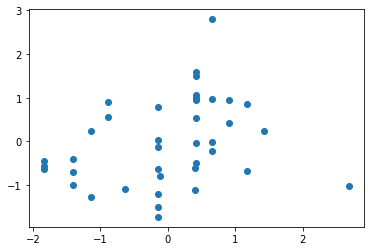

In [ ]:
plt.scatter(df['R_BFG_count_state'],df['target_COV_state'])

# Feature Engineering Pipeline

In [ ]:
#Function lists

func_lists = []

func_lists.append([("outlier_thresh",3),("col_not_startswith","R_"),
             ("col_not_endswith","_y")])

func_lists.append([("outlier_thresh",3),("col_not_startswith","Agg_R"),
             ("col_not_endswith","_x")])

In [ ]:
func_lists = []

func_lists.append([("outlier_thresh",2.5),
                   ("col_not_startswith","R_"),
                   ("col_not_endswith","_y"),
                   ("add_entities",None),
                   ("add_carbon_policy",None),
                   ("standardize_numeric_by_nation",None)])

In [ ]:
see_data = feature_engineering_pipeline(df,Fengine,func_lists[0])

Feature Engineering ( average_weather_columns Temp Standard Deviations  ) Complete
Feature Engineering ( average_weather_columns Temp Averages  ) Complete
Feature Engineering ( average_weather_columns Temp Standard Deviations  ) Complete
Feature Engineering ( average_weather_columns Temp Averages  ) Complete
Feature Engineering ( average_weather_columns PDSI Standard Deviations  ) Complete
Feature Engineering ( average_weather_columns PDSI Averages  ) Complete
Feature Engineering ( average_weather_columns PDSI Standard Deviations  ) Complete
Feature Engineering ( average_weather_columns PDSI Averages  ) Complete
Feature Engineering ( average_weather_columns Standardized Drought  ) Complete
Feature Engineering ( average_weather_columns Standardized Drought  ) Complete
Feature Engineering ( average_weather_columns Standardized Temp  ) Complete
Feature Engineering ( average_weather_columns Standardized Temp  ) Complete


In [ ]:
see_data.head()

,Year,State,COV,target_COV,COM_percapita_mean_kWh_electricacc,RES_percapita_mean_kWh_electricacc,COM_percapita_mean_kWh_statepop,RES_percapita_mean_kWh_statepop,Agg_total_plant_MWh_x,Agg_total_plant_count_x,R_AB_MWh,R_AB_count,R_BFG_MWh,R_BFG_count,R_BIT_MWh,R_BIT_count,R_BLQ_MWh,R_BLQ_count,R_DFO_MWh,R_DFO_count,R_GEO_MWh,R_GEO_count,R_JF_MWh,R_JF_count,R_KER_MWh,R_KER_count,R_LFG_MWh,R_LFG_count,R_LIG_MWh,R_LIG_count,R_MSB_MWh,R_MSB_count,R_MSN_MWh,R_MSN_count,R_MSW_MWh,R_MSW_count,R_MWH_MWh,R_MWH_count,R_NG_MWh,R_NG_count,...,Agg_R_Nuclear_count,Agg_R_Oil_Gas_MWh,Agg_R_Oil_Gas_count,Agg_R_Other_MWh,Agg_R_Other_count,Agg_R_Solar_MWh,Agg_R_Solar_count,Agg_R_Wind_MWh,Agg_R_Wind_count,Agg_R_batteries_or_other_use_of_electricity_as_an_energy_source_MWh,Agg_R_batteries_or_other_use_of_electricity_as_an_energy_source_count,Agg_total_plant_MWh_y,Agg_total_plant_count_y,year.1,x,y,Population Density,Mean Volume Weekly NG=F,Mean Volume Weekly CL=F,Mean Volume Weekly HO=F,Months Above Average Price Movement BZ=F,Months Above Average Price Volume BZ=F,Months Above Average Price Movement NG=F,Months Above Average Price Volume NG=F,Months Above Average Price Movement CL=F,Months Above Average Price Volume CL=F,Months Above Average Price Movement HO=F,Months Above Average Price Volume HO=F,Weighted Temp Standard Deviation Summer Months,Weighted Temp Average Summer Months,Weighted Temp Standard Deviation Winter Months,Weighted Temp Average Winter Months,Weighted PDSI Standard Deviation Summer Months,Weighted PDSI Average Summer Months,Weighted PDSI Standard Deviation Winter Months,Weighted PDSI Average Winter Months,Weighted Summer Month Drought,Weighted Winter Month Drought,Weighted Summer Month Temp,Weighted Winter Month Temp
0,2001,AK,0.035090,0.023952,0.075,0.010,0.435,0.360,5.517773e+06,1032,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.051,0.581,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.543,0.093,...,0.000,0.157,0.605,0.0,0.000,0.000,0.000,0.000,0.012,0.0,0.0,5.517773e+06,1032,NaN,-152.519813,64.570432,0.291700,135165.683333,310770.833333,76504.0875,0,0,7,7,7,7,4,4,1.523238,281.659910,4.039963,255.700800,246.715927,0.750866,266.708810,37.980521,0.312169,-0.026401,-0.398999,0.010411
1,2001,AL,0.030268,0.041504,0.017,0.005,0.240,0.354,1.074304e+08,1089,0.000,0.000,0.0,0.0,0.351,0.110,0.017,0.087,0.003,0.159,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.011,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.082,0.236,...,0.022,0.003,0.192,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,1.074304e+08,1089,NaN,-86.839930,32.627647,34.240621,135165.683333,310770.833333,76504.0875,0,0,7,7,7,7,4,4,1.096826,298.663335,1.815341,283.203405,268.523963,-1.183395,275.910822,16.168707,-0.287143,-0.422936,-0.500970,-0.045779
2,2001,AR,0.067610,0.065392,0.082,0.018,0.223,0.368,4.683797e+07,615,0.000,0.000,0.0,0.0,0.002,0.015,0.023,0.073,0.001,0.098,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.052,0.195,...,0.020,0.019,0.234,0.0,0.018,0.000,0.000,0.000,0.000,0.0,0.0,4.683797e+07,615,NaN,-92.497892,34.899549,18.169515,135165.683333,310770.833333,76504.0875,0,0,7,7,7,7,4,4,1.248317,298.782334,2.008916,280.423569,248.374557,50.270136,241.434544,61.326356,-0.247603,0.123136,0.180839,-0.267678
3,2001,AZ,0.097578,0.091424,0.048,0.007,0.370,0.439,7.170267e+07,575,0.000,0.000,0.0,0.0,0.010,0.021,0.000,0.000,0.002,0.292,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.021,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.173,0.290,...,0.021,0.004,0.355,0.0,0.000,0.000,0.021,0.000,0.000,0.0,0.0,7.170267e+07,575,NaN,-111.719840,34.283152,18.405973,135165.683333,310770.833333,76504.0875,0,0,7,7,7,7,4,4,1.219238,298.090080,1.797809,279.908069,252.782883,43.658828,270.496007,37.100224,-0.202429,-0.607092,0.700192,-0.026019
4,2001,CA,0.145412,0.071167,0.065,0.008,0.408,0.325,1.343136e+08,6470,0.001,0.002,0.0,0.0,0.007,0.006,0.000,0.000,0.001,0.035,0.087,0.048,0.0,0.0,0.0,0.0,0.006,0.028,0.0,0.0,0.0,0.0,0.0,0.0,0.003,0.00

In [ ]:
see_data.shape

(970, 129)

# Executed Pipeline with Logger

In [ ]:
df = pd.read_csv("data/merge_ready/merged_data_2001-2020_new_data.csv")

In [ ]:
import xgboost as xgb
# model_pipeline = [('Linear',[Lasso,Ridge]),('Trees',[ExtraTreesRegressor,RandomForestRegressor])
# model_pipeline = [('Boosting',[HistGradientBoostingRegressor])]
# model_pipeline = [('XGB',[xgb.XGBRegressor])]
model_pipeline = [('Linear',[Lasso,Ridge]),('Trees',[ExtraTreesRegressor,RandomForestRegressor]), 
                  ('Boosting',[GradientBoostingRegressor,HistGradientBoostingRegressor]),('XGB',[xgb.XGBRegressor])]

In [ ]:
model_pipeline

[('Linear',
  [sklearn.linear_model._coordinate_descent.Lasso,
   sklearn.linear_model._ridge.Ridge]),
 ('Trees',
  [sklearn.ensemble._forest.ExtraTreesRegressor,
   sklearn.ensemble._forest.RandomForestRegressor]),
 ('Boosting',
  [sklearn.ensemble._gb.GradientBoostingRegressor,
   sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor]),
 ('XGB', [xgboost.sklearn.XGBRegressor])]

In [ ]:
#!pip install optuna
import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)#WARNING

----------------------------------------------------------------
Feature Engineering Pipeline 0
Feature Engineering ( average_weather_columns Temp Standard Deviations  ) Complete
Feature Engineering ( average_weather_columns Temp Averages  ) Complete
Feature Engineering ( average_weather_columns Temp Standard Deviations  ) Complete
Feature Engineering ( average_weather_columns Temp Averages  ) Complete
Feature Engineering ( average_weather_columns PDSI Standard Deviations  ) Complete
Feature Engineering ( average_weather_columns PDSI Averages  ) Complete
Feature Engineering ( average_weather_columns PDSI Standard Deviations  ) Complete
Feature Engineering ( average_weather_columns PDSI Averages  ) Complete
Feature Engineering ( average_weather_columns Standardized Drought  ) Complete
Feature Engineering ( average_weather_columns Standardized Drought  ) Complete
Feature Engineering ( average_weather_columns Standardized Temp  ) Complete
Feature Engineering ( average_weather_columns Stan

[I 2021-11-29 22:51:15,641] A new study created in memory with name: no-name-cfe92ec9-efce-4271-bf17-b052a1c121e1
[I 2021-11-29 22:51:15,705] Trial 0 finished with value: -0.01877294237384599 and parameters: {'alpha': 27665189.730153862}. Best is trial 0 with value: -0.01877294237384599.


Feature Engineering ( standardize_numeric_by_nation Mean Volume Weekly NG=F ) Complete
Feature Engineering ( standardize_numeric_by_nation Mean Volume Weekly CL=F ) Complete
Feature Engineering ( standardize_numeric_by_nation Mean Volume Weekly HO=F ) Complete
Feature Engineering ( standardize_numeric_by_nation Months Above Average Price Movement NG=F ) Complete
Feature Engineering ( standardize_numeric_by_nation Months Above Average Price Movement CL=F ) Complete
Feature Engineering ( standardize_numeric_by_nation Months Above Average Price Movement HO=F ) Complete
Feature Engineering ( standardize_numeric_by_nation Months Above Average Price Volume NG=F ) Complete
Feature Engineering ( standardize_numeric_by_nation Months Above Average Price Volume CL=F ) Complete
Feature Engineering ( standardize_numeric_by_nation Months Above Average Price Volume HO=F ) Complete
Split Dataset into Train_size = 0.8 Test_size =  0.19999999999999996
----------------------------------------------------

[I 2021-11-29 22:51:15,767] Trial 1 finished with value: -0.01877294237384599 and parameters: {'alpha': 741993192.036492}. Best is trial 0 with value: -0.01877294237384599.
[I 2021-11-29 22:51:15,867] Trial 2 finished with value: -0.01877294237384599 and parameters: {'alpha': 206934278.19940656}. Best is trial 0 with value: -0.01877294237384599.
[I 2021-11-29 22:51:15,950] Trial 3 finished with value: -0.01877294237384599 and parameters: {'alpha': 5151526071.907881}. Best is trial 0 with value: -0.01877294237384599.
[I 2021-11-29 22:51:16,009] Trial 4 finished with value: -0.01877294237384599 and parameters: {'alpha': 3689805742.3717923}. Best is trial 0 with value: -0.01877294237384599.
[I 2021-11-29 22:51:16,045] Trial 5 finished with value: -0.01877294237384599 and parameters: {'alpha': 5776188175.594592}. Best is trial 0 with value: -0.01877294237384599.
[I 2021-11-29 22:51:16,110] Trial 6 finished with value: -0.01877294237384599 and parameters: {'alpha': 7673306486.626406}. Best 

KeyboardInterrupt: ignored

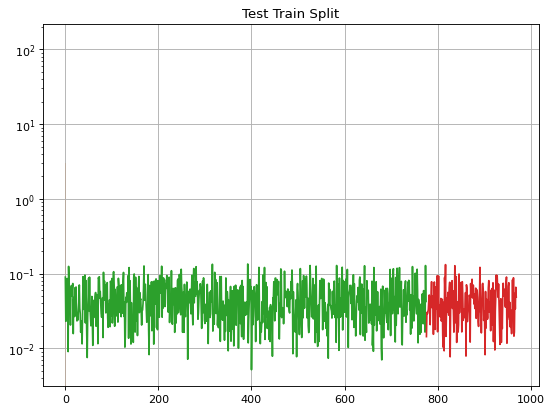

In [ ]:
from sklearn.metrics import explained_variance_score,r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV


plt.figure(figsize=(8, 6), dpi=80)


# Iterate over feature engineering
for index, func_list in enumerate(func_lists):

    print_header(f"Feature Engineering Pipeline {index}")

    df_model = feature_engineering_pipeline(df,Fengine,func_list)

    X,y,X_train,X_test,y_train,y_test = split_dataset(df_model,train_size=0.80,
                                                  target="target_COV")

    plot_test_train(X_train,X_test,y_train,y_test)

#Modeling
    for label,models in model_pipeline:

        print_header("Models tested")

        print(label,models)


        for model in models:

                print("Model tested")
                print(type(model()).__name__)

                #One offs
                #print("Nulls {}, {}, {}, {}".format(np.isnan(X_train).sum(),np.isnan(y_train).sum(),np.isnan(X_test).sum(),np.isnan(y_test).sum()))
                results = fit_model_predict(model,label,X_train,X_test,y_train,y_test)
                custom_model_name = type(model()).__name__

                #Sets of models
                # results = fit_model_predict(model[0],label,X_train,X_test,y_train,y_test)
                # custom_model_name = type(model[0]).__name__

                #Grid CV
                # results = fit_grid_cv(model,X_train,y_train,score="r2",cv=3)
                # custom_model_name = type(model[0]).__name__


                            
                #Inits Neptune
                run = neptune.init(project=neptune_project_name,
                                    api_token=get_neptune_key(name),)# your credentials


                headers = {"Cust_Columns":[X.reset_index().columns.tolist()],
                                "Cust_Pipeline_funcs":[func_list],"Cust_Model":custom_model_name}

                for key,value in headers.items():
                    
                    results[key] = value

                run["results/"] = results

                _ = run.stop()



In [ ]:
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.4,max_depth=3)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
r2 = r2_score(y_train,y_train_pred)
print(r2)

[22:51:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9984787481827604


In [ ]:
r2_test = r2_score(y_test,model.predict(X_test))
r2_test

0.5525331574166095

# Analyze Results

In [ ]:
# Fetch project 'jack/sandbox'
project = neptune.get_project(name=neptune_project_name,api_token=get_neptune_key(name))

# Fetch all Runs metadata as Pandas DataFrame
runs_table_df = project.fetch_runs_table().to_pandas()

runs_table_df.columns =  [col.split("/")[2] if "Parameters" in col else col.split("/")[1] for col in runs_table_df.columns]

In [ ]:
runs_table_df.sort_values(by='R2_test',ascending=False)[['R2_test','R2_train','owner','Adj_R2_test','Adj_R2_train','MSE_test','MSE_train']].head(50)

,R2_test,R2_train,owner,Adj_R2_test,Adj_R2_train,MSE_test,MSE_train
119,0.73,0.73,himanshu2512,0.701500,0.723389,0.000208,2.049000e-04
105,0.73,0.90,adamgoldsteindatascience,0.698146,0.897287,0.000173,7.689439e-05
40,0.72,0.93,adamgoldsteindatascience,0.344471,0.918282,0.000182,5.650597e-05
14,0.72,0.93,adamgoldsteindatascience,0.344471,0.918282,0.000182,5.650597e-05
53,0.71,0.93,adamgoldsteindatascience,0.445096,0.920500,0.000185,5.869836e-05
27,0.70,0.92,adamgoldsteindatascience,0.271951,0.906195,0.000194,6.113351e-05
80,0.70,0.90,adamgoldsteindatascience,0.612338,0.894000,0.000194,7.732056e-05
54,0.69,0.90,adamgoldsteindatascience,0.406827,0.886429,0.000199,7.578320e-05
107,0.69,0.94,adamgoldsteindatascience,0.653427,0.938372,0.000201,5.051533e-05
10,0.69,1.00,harperd17,0.363511,1.000000,0.000189,6.542286e-31


In [ ]:
!pip install optuna
import optuna

     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 80 kB 8.5 MB/s 
     |████████████████████████████████| 209 kB 52.8 MB/s 
     |████████████████████████████████| 75 kB 4.6 MB/s 
     |████████████████████████████████| 112 kB 57.7 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
     |████████████████████████████████| 149 kB 53.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=cd4def43e56c3e5bca0ef3a85078fa3ca1ac2294a78cadac6427e59fe49c2cc0
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
param_distributions = {"alpha": optuna.distributions.LogUniformDistribution(1e-10, 1e10)}
optuna_search = optuna.integration.OptunaSearchCV(Lasso(), param_distributions,cv=5, n_trials=100)
optuna_search.fit(X_train, y_train)
#y_train_pred = optuna_search.predict(X_train)

[I 2021-11-24 19:49:51,250] A new study created in memory with name: no-name-479f4ccd-4039-491e-a7b7-cb04ace7fcfa
[I 2021-11-24 19:49:51,294] Trial 0 finished with value: -0.01877294237384599 and parameters: {'alpha': 13.078506301172556}. Best is trial 0 with value: -0.01877294237384599.
[I 2021-11-24 19:49:51,447] Trial 1 finished with value: 0.5954842684453585 and parameters: {'alpha': 0.00017487800601025995}. Best is trial 1 with value: 0.5954842684453585.
[I 2021-11-24 19:49:51,471] Trial 2 finished with value: -0.01877294237384599 and parameters: {'alpha': 2369131029.9591446}. Best is trial 1 with value: 0.5954842684453585.
[I 2021-11-24 19:49:51,516] Trial 3 finished with value: 0.3944687183392594 and parameters: {'alpha': 0.0008205863359182127}. Best is trial 1 with value: 0.5954842684453585.
[I 2021-11-24 19:49:52,064] Trial 4 finished with value: 0.6719743445461679 and parameters: {'alpha': 8.935067738485735e-10}. Best is trial 4 with value: 0.6719743445461679.
[I 2021-11-24 1

OptunaSearchCV(estimator=Lasso(), n_trials=100,
               param_distributions={'alpha': LogUniformDistribution(high=10000000000.0, low=1e-10)})

In [ ]:
optuna_search.best_params_

{'alpha': 1.6856599148421353e-05}

In [ ]:
optuna_search.best_score_

0.6898058181807643

In [ ]:
r2_score(y_train,y_preds_train)

0.7606056474776971

In [ ]:
r2_score(y_preds_train,y_train)

0.6852582500324439

In [ ]:
import statsmodels.api as sm

In [ ]:
X_train_constant = sm.add_constant(X_train)
mod = sm.OLS(y_train,X_train_constant)
res = mod.fit()

In [ ]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     28.39
Date:                Wed, 24 Nov 2021   Prob (F-statistic):          7.88e-169
Time:                        19:12:00   Log-Likelihood:                 2244.6
No. Observations:                 776   AIC:                            -4331.
Df Residuals:                     697   BIC:                            -3964.
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.498      0.619      -0.002       0.001
x1             0.3337      0.033     10.188      0.000       0.269       0.398
x2            -0.0392      0.029     -1.340      0.181      -0.097       0.018
x3             0.3363      0.187      1.796      0.073      -0.031       0.704
x4          1.351e-06    8.8e-07      1.535      0.125   -3.77e-07    3.08e-06
x5            -0.2969      0.690     -0.430      0.667      -1.651       1.057
x6            -0.3188      0.686     -0.465      0.642      -1.665       1.028
x7            -0.1132      0.715     -0.158      0.874      -1.517       1.291
x8            -0.3187      0.686     -0.465      0.642      -1.666       1.028
x9             0.2421      0.723      0.335      0.738      -1.178       1.662
x10           -0.3097      0.685     -0.452      0.652      -1.655       1.036
x11           -0.3018      0.686     -0.440      0.660      -1.648       1.045
x12           -0.3038      0.686     -0.443      0.658      -1.650       1.042
x13           -0.2569      0.740     -0.347      0.729      -1.709       1.196
x14           -0.2965      0.685     -0.433      0.665      -1.641       1.048
x15           -0.3201      0.686     -0.467      0.641      -1.666       1.026
x16            2.4423      6.956      0.351      0.726     -11.215      16.100
x17           -0.0044      0.004     -1.010      0.313      -0.013       0.004
x18            0.0048      0.002      2.042      0.042       0.000       0.009
x19           -0.0003      0.002     -0.139      0.890      -0.005       0.005
x20           -0.0040      0.001     -3.671      0.000      -0.006      -0.002
x21        -2.942e-06   9.51e-05     -0.031      0.975      -0.000       0.000
x22            0.0001   6.71e-05      1.726      0.085   -1.59e-05       0.000
x23         5.637e-05      0.000      0.513      0.608      -0.000       0.000
x24        -5.689e-05   6.28e-05     -0.906      0.365      -0.000    6.63e-05
x25           -0.0036      0.002     -2.243      0.025      -0.007      -0.000
x26            0.0037      0.002      2.247      0.025       0.000       0.007
x27           -0.0050      0.001     -4.120      0.000      -0.007      -0.003
x28            0.0003      0.001      0.306      0.759      -0.002       0.002
x29            0.0012      0.003      0.378      0.706      -0.005       0.008
x30           -0.0064      0.010     -0.659      0.510      -0.025       0.013
x31            0.0009      0.003      0.252      0.801      -0.006       0.008
x32           -0.0015      0.003     -0.450      0.653      -0.008       0.005
x33            0.0059      0.004      1.332      0.183      -0.003       0.014
x34           -0.0033      0.006     -0.579      0.563      -0.015       0.008
x35           -0.0015      0.007     -0.228      0.820      -0.014       0.011
x3

In [ ]:
from scipy.stats import linregress

In [ ]:
print(y_train.shape)
print(X_train.shape)

(776,)
(776, 99)


In [ ]:
y_train.reshape(-1,1).shape

(776, 1)

In [ ]:
y_train.T.shape

(776,)

In [ ]:
np.concatenate((X_train,y_train.reshape(-1,1)),axis=0)

ValueError: ignored

In [ ]:
slope, intercept, r_value, p_value, std_err = linregress(X_train.T, y_train.reshape(-1,1).T)

ValueError: ignored

In [ ]:
r2_score(y_preds_train,y_train)

TypeError: ignored

In [ ]:
y_preds_train = res.predict(sm.add_constant(X_train))
y_preds_test = res.predict(sm.add_constant(X_test))

In [ ]:
RSS_test = ((y_preds_test-y_test)**2).sum()
RTT_test = ((y_test-y_test.mean())**2).sum()
r2_test = 1-RSS_test/RTT_test
print(r2_test)

0.6256468756114006


In [ ]:
np.sqrt(((y_preds_test-y_test)**2).mean())

0.0150377623286495

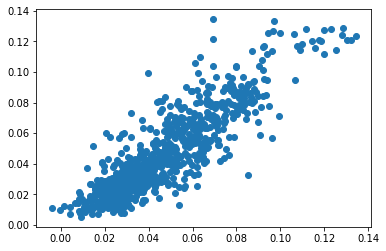

In [ ]:
plt.scatter(y_preds_train,y_train)

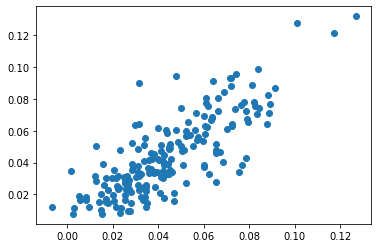

In [ ]:
plt.scatter(y_preds_test,y_test)

In [ ]:
r2_train  = round(r2_score(y_preds_train,y_train),2)
r2_train

0.69

In [ ]:
RSS = ((y_preds_train-y_train)**2).sum()
RTT = ((y_train-y_train.mean())**2).sum()
r2 = 1-RSS/RTT
print(r2)

0.7606056474776973


In [ ]:
N = X.shape[0]
K = X.shape[1]

In [ ]:
adjusted_r2 = 1 - (RSS/(N-K))/(RTT/(N-1))#1-(1-r2)*(N-K-1)/(N-1)
print(adjusted_r2)

0.7336703471939021


In [ ]:
adjusted_r2_train = calc_adjusted_r2(X_train,r2_train)
print(adjusted_r2_train)
#adjusted_r2_test = calc_adjusted_r2(X_test,r2_test)

mse_value_train = mse(y_preds_train,y_train)
print(mse_value_train)

0.6446005917159763
0.0001799326984088624


In [ ]:
np.sqrt(((y_preds_train-y_train)**2).mean())

0.01341389944829103

In [ ]:
|
runs_table_df['creation_time'] = pd.to_datetime(runs_table_df['creation_time'])

In [ ]:
runs_table_df

,creation_time,description,failed,hostname,id,modification_time,monitoring_time,name,owner,ping_time,running_time,size,state,tags,Adj_R2_test,Adj_R2_train,Coef_train,Cust_Columns,Cust_Model,Cust_Pipeline_funcs,Explained_Variance_Score_test,Explained_Variance_Score_train,MSE_test,MSE_train,alpha,base_score,booster,colsample_bylevel,colsample_bynode,colsample_bytree,copy_X,fit_intercept,gamma,importance_type,learning_rate,max_delta_step,max_depth,max_iter,min_child_weight,missing,n_estimators,n_jobs,normalize,nthread,objective,positive,precompute,random_state,reg_alpha,reg_lambda,scale_pos_weight,seed,selection,silent,subsample,tol,verbosity,warm_start,R2_test,R2_train,y_preds_test,y_preds_train,gpu_memory,memory,stdout
0,2021-11-23 22:01:51.718000+00:00,,False,ca2023db8d92,EN-527,2021-11-23 22:01:54.969000+00:00,602,Untitled,adamgoldsteindatascience,2021-11-23 22:01:54.969000+00:00,3.250,17068.0,idle,,-104.094528,-100.005769,[-0.00000000e+00 -0.00000000e+00 -0.00000000e+...,"[['index', 'State', 'Months Above Average Pric...",Lasso,"[[('outlier_thresh', 3), ('col_not_startswith'...",-54.58,-88.19,0.000766,0.000760,1.0,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,deprecated,NaN,NaN,False,False,None,NaN,NaN,NaN,NaN,cyclic,NaN,NaN,0.0001,NaN,False,-54.98,-88.19,[0.04633066 0.04743528 0.0462924 0.04661055 0...,[0.05008786 0.05174153 0.04405032 0.04819989 0...,0.282349,0.448475,"b'Shutting down background jobs, please wait a..."
1,2021-11-23 22:01:47.851000+00:00,,False,ca2023db8d92,EN-526,2021-11-23 22:01:50.998000+00:00,602,Untitled,adamgoldsteindatascience,2021-11-23 22:01:50.998000+00:00,3.147,17012.0,idle,,0.061321,0.490385,[-9.47567719e-05 -2.02089320e-02 7.80579317e-...,"[['index', 'State', 'Months Above Average Pric...",LinearRegression,"[[('outlier_thresh', 3), ('col_not_startswith'...",0.50,0.55,0.000252,0.000241,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,deprecated,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50,0.55,[ 0.02146559 0.01827059 0.03314459 0.041879...,[0.03105055 0.04060757 0.06048119 0.02967938 0...,0.282349,0.448086,"b'Shutting down background jobs, please wait a..."
2,2021-11-23 22:01:45.264000+00:00,,False,ca2023db8d92,EN-525,2021-11-23 22:01:47.159000+00:00,601,Untitled,adamgoldsteindatascience,2021-11-23 22:01:47.159000+00:00,1.894,16136.0,idle,,-2185.897358,-1238.407265,None,"[['index', 'State', 'Months Above Average Pric...",XGBRegressor,"[[('outlier_thresh', 3), ('col_not_startswith'...",-26.05,-24.83,0.026152,0.025613,10.0,0.5,gbtree,1.0,1.0,0.3,NaN,NaN,0.0,gain,0.1,0.0,5.0,NaN,1.0,None,10.0,1,NaN,None,reg:linear,NaN,NaN,0,0.0,1.0,1.0,None,NaN,None,1.0,NaN,1.0,NaN,-1163.88,-1093.42,[0.20172355 0.20172355 0.20485157 0.2031022 0...,[0.20172355 0.20172355 0.21159485 0.20172355 0...,0.282349,0.448509,"b'Shutting down background jobs, please wait a..."
3,2021-11-23 22:01:42.486000+00:00,,False,ca2023db8d92,EN-524,2021-11-23 22:01:44.403000+00:00,601,Untitled,adamgoldsteindatascience,2021-11-23 22:01:44.403000+00:00,1.917,15872.0,idle,,-70.410385,-93.289960,[-0.00000000e+00 -0.00000000e+00 -0.00000000e+...,"[['index', 'State', 'Months Above Average Pric...",Lasso,"[[('outlier_thresh', 3), ('col_not_startswith'...",-54.58,-88.19,0.000766,0.000760,1.0,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,deprecated,NaN,NaN,False,False,None,NaN,NaN,NaN,NaN,cyclic,NaN,NaN,0.0001,NaN,False,-54.98,-88.19,[0.04633066 0.04743528 0.0462924 0.04661055 0...,[0.05008786 0.05174153 0.04405032 0.04819989 0...,0.282349,0.448051,"b'Shutting down background jobs, please wait a..."
4,2021-11-23 22:01:37.923000+00:00,,False,ca2023db8d92,EN-523,2021-11-23 22:01:40.867000+00:00,601,Untitled,adamgoldsteindatascience,2021-11-23 22:01:40.867000+00:00,2.944,15614.0,idle,,0.311154,0.418551,[-9.09149293e-05 -2.08460525e-02 4.09899065e-...,"[['index', 'State', 'Months Above Average Pric...",LinearRegression,"[[('outlier_thresh', 3), ('col

In [ ]:
import plotly.express as px

(px.line(runs_table_df.query('Adj_R2_test > .40').sort_values("creation_time",ascending=False),x="creation_time",y="Adj_R2_test",color="Cust_Model",hover_data=["Adj_R2_test","Adj_R2_test"],
        
        log_y=True,title="Model Performance - Adjusted R2")
        
        .for_each_trace(lambda t: t.update(name=t.name.replace("Cust_Model=","")))
        
        )

In [ ]:
import plotly.express as px

(px.line(runs_table_df.sort_values("creation_time",ascending=False),x="creation_time",y="MSE_test",color="Cust_Model",hover_data=["Adj_R2_test"],
        
        log_y=True,title="Model Performance - MSE")
        
        .for_each_trace(lambda t: t.update(name=t.name.replace("Cust_Model=","")))
        
        )